[UCI]:https://archive.ics.uci.edu/ml/datasets/Synthetic+Control+Chart+Time+Series
[SPDM]:http://www.cs.ucr.edu/~eamonn/shaplet.pdf
[LTSS]:https://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

# Time series classification using shapelets

This notebook aims to classify the synthetic time-series from the Synthetic Control Chart Time Series Data Set found at [UCI], using shapelets. It is based on the work by [J. Grabocka et al.][LTSS] (2009) and its tslearn implementation.

**Shapelets**

First introduced by  [Ye and Keogh][SPDM] (2009), shapelets are time-series subsequences used to represent classes, and thus discriminate between different classes. Instead of calculating distances between entire series, one calculates the distance of series to the shapelets.

[J. Grabocka et al.][LTSS] (2009) greatly improved upon the idea by automating the discovery of shapelets. Before their work, shapelets were exhaustively search throughout the dataset. This was computationally intensive and  only subsquences found in the dataset could be found as most representative of a class. 

In [1]:
import numpy as np
from keras.optimizers import Adagrad
from sklearn.metrics import accuracy_score
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


# Data

In [2]:
data = np.load('data/synthetic_control')

The data consist in 6\*100 time-series of length 60. Each group of a 100 is drawn from a different distribution.  
We plot below examples from each of the groups. 

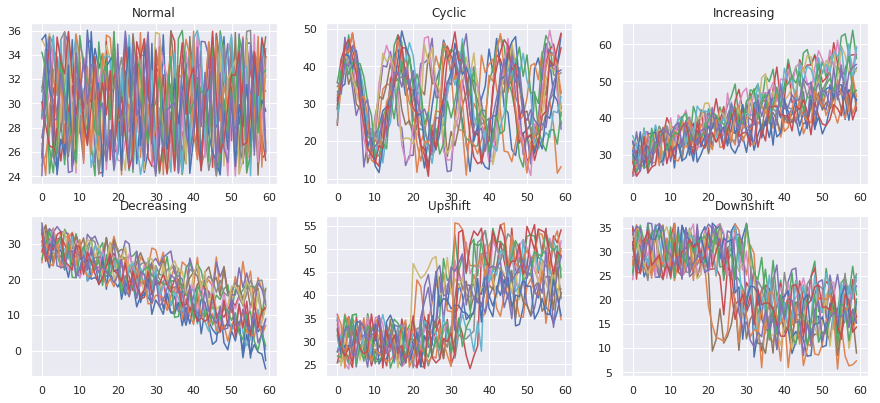

In [3]:
f, axarr = plt.subplots(2, 3, figsize=(15,6.5))
axarr[0, 0].plot(data[0:15].T)
axarr[0, 0].set_title('Normal')
axarr[0, 1].plot(data[100:115].T)
axarr[0, 1].set_title('Cyclic')
axarr[0, 2].plot(data[200:215].T)
axarr[0, 2].set_title('Increasing')
axarr[1, 0].plot(data[300:315].T)
axarr[1, 0].set_title('Decreasing')
axarr[1, 1].plot(data[400:415].T)
axarr[1, 1].set_title('Upshift')
axarr[1, 2].plot(data[500:515].T)
axarr[1, 2].set_title('Downshift');

# Classifying with Shapelets

We first create a train and a test set.

In [4]:
y = np.concatenate(([0]*100 ,[1]*100,[2]*100,[3]*100,[4]*100,[5]*100))
X = TimeSeriesScalerMinMax().fit_transform(data)
np.random.seed(42)
train_set_size = 350  # 600 total
train_set_index = np.random.choice(np.arange(data.shape[0]), train_set_size, replace=False)
test_set_index = np.setdiff1d(np.arange(data.shape[0]), train_set_index)
X_train = X[train_set_index]
y_train = y[train_set_index]
X_test = X[test_set_index]
y_test = y[test_set_index]

In [5]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=len(set(y_train)),
                                                       l=0.1,
                                                       r=3)

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=Adagrad(lr=.1),
                        weight_regularizer=.01,
                        max_iter=800,
                        verbose_level=0)
shp_clf.fit(X_train, y_train)
print('Test-set accuracy: {}'.format(accuracy_score(shp_clf.predict(X_test), y_test)))

Test-set accuracy: 0.968


We know look at the prediction given by the shapelet model. As a reminder, the true classes are 0\*100, 1\*100, ..., 5*100.

In [6]:
shp_clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

Below are the shapelets found by the model, as well as the best-match location of the shapelets on a random series.

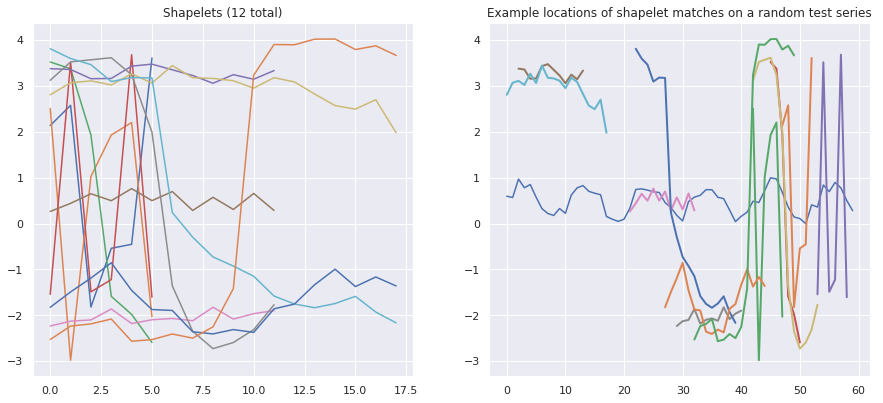

In [7]:
f, axarr = plt.subplots(1, 2, figsize=(15,6.5))
for shp in shp_clf.shapelets_:
    axarr[0].plot(shp)
axarr[0].set_title('Shapelets ({} total)'.format(sum(shapelet_sizes.values())));


predicted_locations = shp_clf.locate(X_test)  # get the shapelets best matches for every series
random_ts_id = np.random.choice(X_test.shape[0])  # pick a random test series

axarr[1].plot(X_test[random_ts_id])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[random_ts_id, idx_shp]
    axarr[1].plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
    axarr[1].set_title("Example locations of shapelet matches on a random test series");

The shapelets learned by the model reflect well discriminative features of the dataset. There are some flat shapelets, some with trends and some with shifts. 

### Errors analysis


We now plot some misclassified series.

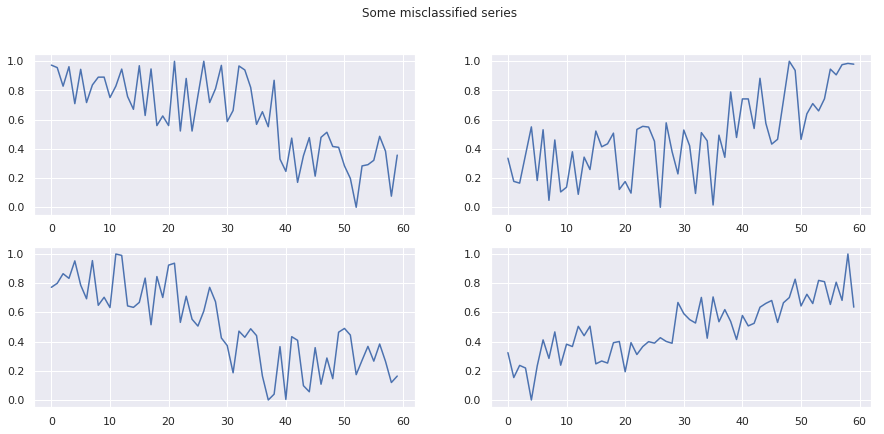

In [8]:
misclassified_id = np.where(shp_clf.predict(X) != y)[0]  # array of all misclassified ts indices

f, axarr = plt.subplots(2, 2, figsize=(15,6.5))
for i,j in product([0,1],[0,1]):
    axarr[i,j].plot(X[:, :, 0][np.random.choice(misclassified_id)])
f.suptitle('Some misclassified series');

Some of the above misclassified series are not necessarily easy to classify, even for the human eye. 

[UFLTS]: https://www.ijcai.org/Proceedings/16/Papers/331.pdf

# Next steps

[Q. Zhang et al][UFLTS] (2016) describe an algorithm to cluster (no label) time-series with shapelets. I will try to implement it and see if it gets better accuracy than "naive" distance calculations over the entire series (see my Clustering_Synthetic_Time_Series notebook).